In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import time
from matplotlib.animation import FuncAnimation
import time

class SpectrumEnvironment:
    def __init__(self, num_bands=10, steps=25,detection_method="energy_detection"):
        self.num_bands = num_bands  # Total number of frequency bands
        self.steps = steps
        self.channel_states = [[] for _ in range(num_bands)]
        self.transition_matrices = self._initialize_transition_matrices()
        self.total_reward = 0  # Track total reward
        self.rewards = []  # Track rewards for each step
        self.energy_costs = [[] for _ in range(num_bands)]
        valid_methods = ["energy_detection", "matched_filter", "cyclostationary"]
        if detection_method not in valid_methods:
            raise ValueError(f"Invalid detection method. Choose from {valid_methods}")
        self.detection_method = detection_method
        self.state = self._generate_spectrum_state()  # Current state of the spectrum
    
    def _initialize_transition_matrices(self):
        """
        Generate a unique random Markov chain transition matrix for each band.
        Each matrix ensures that the probabilities in each row sum to 1.
        """
        matrices = []
        for _ in range(self.num_bands):
            # Generate a random 2x2 matrix
            random_matrix = np.random.rand(2, 2)
            # Normalize each row to sum to 1
            transition_matrix = random_matrix / random_matrix.sum(axis=1, keepdims=True)
            matrices.append(transition_matrix)
        return matrices
    
    def energy_detection(self, time_step, band, delta=0.1, noise_floor=0.05):
        """
        Perform energy detection for a specific band and timestep.
        Simulates energy detection with a noise floor threshold.
    
        Parameters:
        - time_step (int): The timestep to evaluate.
        - band (int): The band (channel) number to evaluate.
        - delta (float): The change in energy state for transitions (default: 0.1).
        - noise_floor (float): The noise floor threshold for detection (default: 0.05).
    
        Returns:
        - detection_result (int): 1 if channel is occupied, 0 otherwise.
        - energy (float): Calculated energy for the band and timestep.
        """
        # Ensure valid inputs
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")
    
        # Current state and previous energy
        current_state = self.channel_states[band][time_step]
        previous_energy = self.energy_costs[band][-1] if self.energy_costs[band] else 0
    
        # Calculate new energy state
        new_energy = previous_energy + (delta if current_state == 1 else 0)
        self.energy_costs[band].append(new_energy)
    
        # Detection decision
        detection_result = 1 if new_energy > noise_floor else 0
        return detection_result, new_energy


    def matched_filter_fft(self, time_step, band, snr_boost=10):
        """
        Simulates matched filter detection with FFT and adaptive energy consumption.
    
        Parameters:
        - band (int): The band (channel) to evaluate.
        - time_step (int): The time step for the evaluation.
        - snr_boost (float): The signal-to-noise ratio improvement for state 1 (default: 10).
    
        Returns:
        - detection_result (int): 1 if signal is detected, 0 otherwise.
        - energy_consumption (float): Energy consumed for the operation.
        """
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")
    
        current_state = self.channel_states[band][time_step]
        base_energy = 0.2
        state_energy = 0.1 if current_state == 1 else 0.05
        history_energy = 0.02 + (self.energy_costs[band][-1] if self.energy_costs[band] else 0)
    
        # Simulated SNR improvement for matched filter
        snr = snr_boost if current_state == 1 else 0
        detection_result = 1 if snr > 5 else 0
    
        total_energy_consumption = base_energy + state_energy + history_energy
        self.energy_costs[band].append(total_energy_consumption)
    
        return detection_result, total_energy_consumption


    def cyclostationary_detection(self, time_step, band, periodicity_threshold=0.5):
        """
        Simulates cyclostationary feature detection based on periodic properties.
    
        Parameters:
        - band (int): The band (channel) to evaluate.
        - time_step (int): The time step for the evaluation.
        - periodicity_threshold (float): Threshold for periodicity detection (default: 0.5).
    
        Returns:
        - detection_result (int): 1 if periodic features are detected, 0 otherwise.
        - energy_consumption (float): Energy consumed for the operation.
        """
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")
    
        current_state = self.channel_states[band][time_step]
        base_energy = 0.15
        state_energy = 0.07 if current_state == 1 else 0.03
        history_energy = 0.015 + (self.energy_costs[band][-1] if self.energy_costs[band] else 0)
    
        # Simulated periodicity score
        periodicity_score = np.random.uniform(0, 1) if current_state == 1 else 0
        detection_result = 1 if periodicity_score > periodicity_threshold else 0
    
        total_energy_consumption = base_energy + state_energy + history_energy
        self.energy_costs[band].append(total_energy_consumption)
    
        return detection_result, total_energy_consumption
    
    def detect(self,time_step,band):
        if self.detection_method == "energy_detection":
            return self.energy_detection(time_step, band)
        elif self.detection_method == "matched_filter":
            return self.matched_filter_fft(time_step, band)
        elif self.detection_method == "cyclostationary":
            return self.cyclostationary_detection(time_step, band)
    
    def _generate_spectrum_state(self):
        """
        Generate a spectrum state using Markov chain dynamics for each band.
        Simulates energy, SNR, or periodicity based on the detection method.
        """
        new_states = []
    
        for band in range(self.num_bands):
            # Get the last state or default to 0 if no history exists
            last_state = self.channel_states[band][-1] if self.channel_states[band] else 0
    
            # Generate states for the next 'steps' timesteps using the Markov chain
            band_states = []
            for time_step in range(self.steps):
                # Determine the next state based on the Markov chain
                transition_probabilities = self.transition_matrices[band][last_state]
                next_state = np.random.choice([0, 1], p=transition_probabilities)
                # Update state and history
                band_states.append(next_state)
                last_state = next_state  # Update for the next step
            # Append the generated states to history
            self.channel_states[band] = band_states
        return self.channel_states
    
    def step(self, time_step, band):
        """
        Perform a step in the simulation, calculate reward, and log detection results.
    
        Parameters:
        - time_step (int): The time step to evaluate.
        - band (int): The band (channel) number to evaluate.
    
        Returns:
        - reward (int): The reward gained from the channel's state and detection result.
        """
        # Ensure the inputs are within valid ranges
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")
    
        # Get the state of the specified channel at the given timestep
        state = self.channel_states[band][time_step]
    
        # Perform detection and log results
        #detection_result, energy_consumption = self.detect(time_step, band)
    
        # Calculate the reward based on the state and detection result
        if state == 0:
            reward = 30  # Correctly identified idle channel
        else:
            reward = 15  # Correctly identified occupied channel
        
        # Update total reward and log step details
        #self.total_reward += reward
        self.rewards.append({
            "time_step": time_step,
            "band": band,
            "state": state,
            "reward": reward,
        })
    
        return reward

    
    def soft_reset(self):
        self.energy_costs = [[] for _ in range(self.num_bands)]
        

In [35]:
class QLearningAgent:
    def __init__(self, environment, alpha=0.1, gamma=0.9, epsilon=0.2):
        """
        Initialize the Q-learning agent.

        Parameters:
        - environment: The SpectrumEnvironment object.
        - alpha (float): Learning rate.
        - gamma (float): Discount factor.
        - epsilon (float): Exploration probability.
        """
        self.env = environment
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Q-table: States are (time_step), actions are (2 * num_bands)
        self.q_table = np.zeros((self.env.steps, 2 * self.env.num_bands))

    def choose_action(self, state):
        """
        Choose an action based on epsilon-greedy policy.

        Parameters:
        - state (tuple): The current state (time_step).

        Returns:
        - action (int): The selected action (band and energy detection choice).
        """
        time_step = state[0]
        if np.random.rand() < self.epsilon:
            # Exploration: Randomly select an action
            return np.random.randint(0, 2 * self.env.num_bands)
        else:
            # Exploitation: Select the action with the highest Q-value
            return np.argmax(self.q_table[time_step])

    def update_q_table(self, state, action, reward, next_state):
        """
        Update the Q-value for a given state-action pair.

        Parameters:
        - state (tuple): The current state (time_step).
        - action (int): The chosen action (band and energy detection).
        - reward (float): The reward received.
        - next_state (tuple): The next state (time_step + 1).
        """
        time_step = state[0]
        next_time_step = next_state[0]

        # Get the maximum Q-value for the next state
        max_next_q = np.max(self.q_table[next_time_step])

        # Update the Q-value using the Q-learning formula
        self.q_table[time_step, action] += self.alpha * (
            reward + self.gamma * max_next_q - self.q_table[time_step, action]
        )

    def train(self, episodes):
        """
        Train the agent over multiple episodes.

        Parameters:
        - episodes (int): Number of episodes to train the agent.
        """
        total_rewards_per_episode = []  # Track total rewards per episode for visualization

        for episode in range(episodes):
            print(f"Episode {episode + 1}/{episodes}")

            # Reset the environment state and energy history
            self.env._generate_spectrum_state()
            self.env.soft_reset()
            total_reward = 0

            # Start at the first timestep
            for time_step in range(self.env.steps - 1):
                state = (time_step,)
                action = self.choose_action(state)
            
                band = action % self.env.num_bands
                use_energy_detection = action >= self.env.num_bands
            
                # Detection result and energy consumption
                raw_reward = self.env.step(time_step, band)
                if use_energy_detection:
                    detection_result, energy_consumption = self.env.detect(time_step, band)
                    if detection_result and self.env.channel_states[band][time_step] == 0:
                        reward = raw_reward - energy_consumption
                    elif not detection_result and self.env.channel_states[band] == 0:
                        reward = raw_reward - energy_consumption
                    else:
                        reward = -raw_reward - energy_consumption
                else:
                    reward = raw_reward
                    
                next_state = (time_step + 1,)
                self.update_q_table(state, action, reward, next_state)
                total_reward += reward

            total_rewards_per_episode.append(total_reward)
            print(f"Total Reward for Episode {episode + 1}: {total_reward}")

        # Plot learning progress
        plt.plot(total_rewards_per_episode)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Learning Progress")
        plt.show()



energy_detection


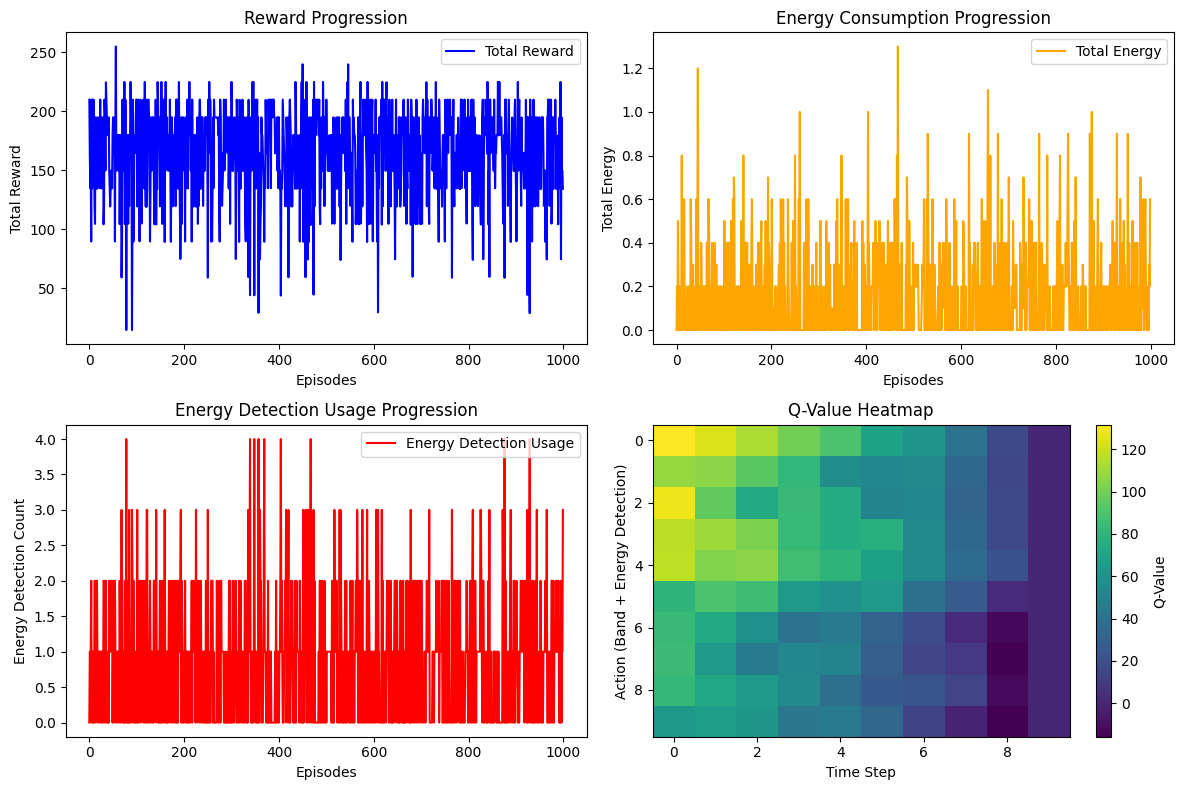

matched_filter


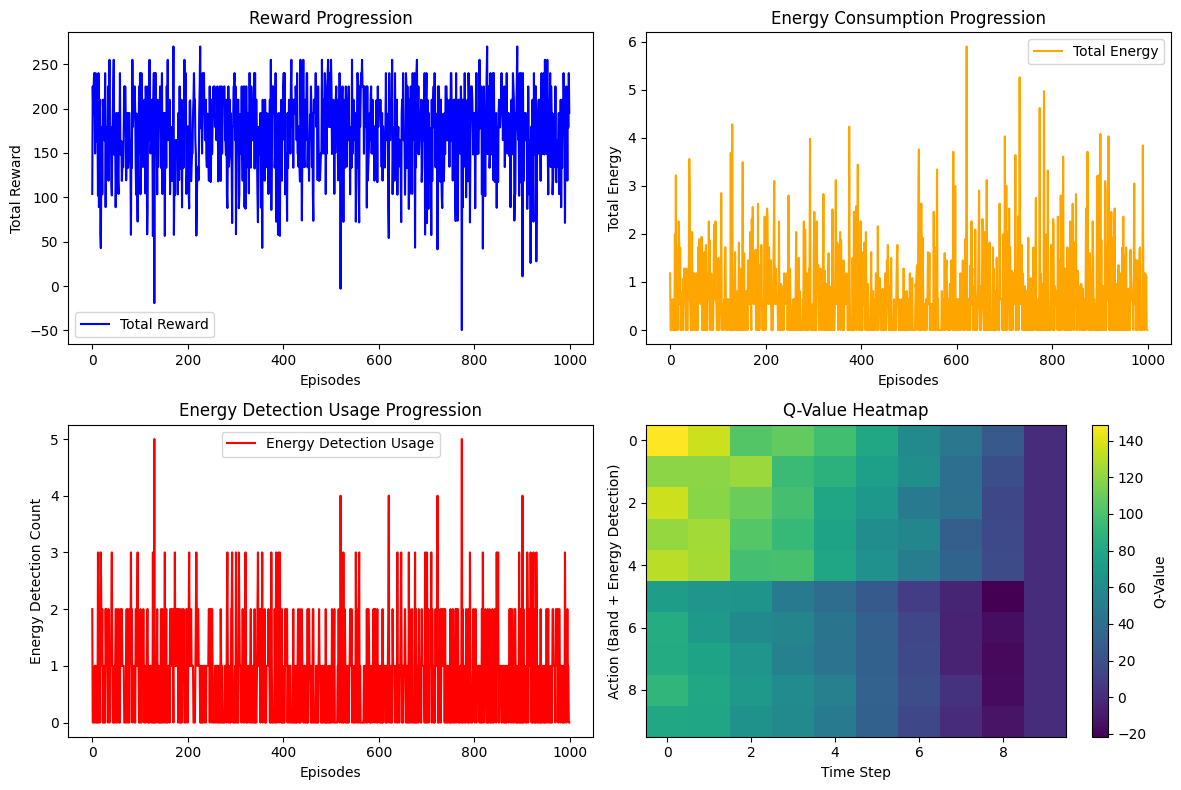

cyclostationary


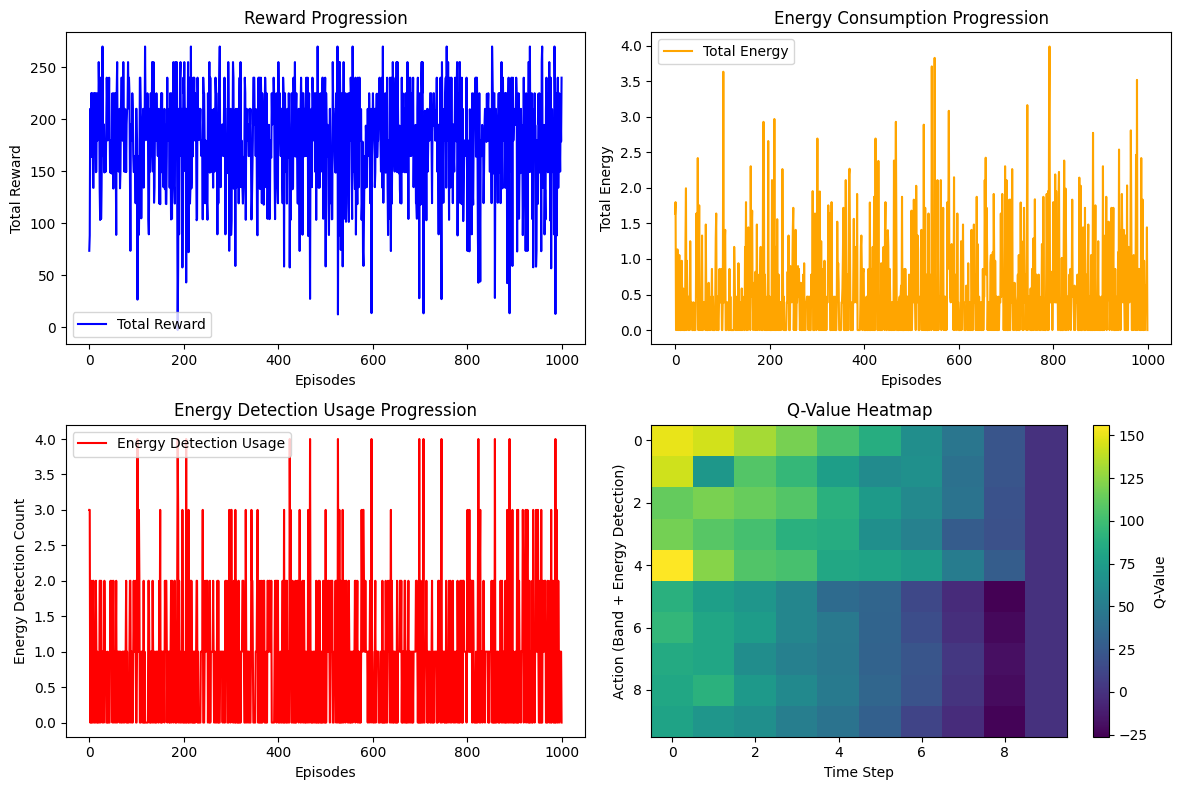

In [36]:
class QLearningAgentWithVisualization(QLearningAgent):
    def __init__(self, environment, alpha=0.1, gamma=0.9, epsilon=0.2):
        super().__init__(environment, alpha, gamma, epsilon)
        self.episode_rewards = []  # Track total rewards per episode
        self.episode_energy = []  # Track total energy consumption per episode
        self.action_counts = np.zeros(2 * self.env.num_bands)  # Track action selection frequency
        self.energy_detection_usage = []  # Track how often energy detection is used per episode

    def train(self, episodes):
        """
        Train the agent over multiple episodes with visualization tracking.
        
        Parameters:
        - episodes (int): Number of episodes to train the agent.
        """
        for episode in range(episodes):
            # Reset environment for each episode
            self.env._generate_spectrum_state()
            self.env.soft_reset()
            total_reward = 0
            total_energy = 0
            energy_detection_count = 0

            for time_step in range(self.env.steps - 1):
                state = (time_step,)
                action = self.choose_action(state)
                self.action_counts[action] += 1
            
                band = action % self.env.num_bands
                use_energy_detection = action >= self.env.num_bands
            
                # Detection result and energy calculation
                detection_result, energy_consumption = self.env.detect(time_step, band)
                if use_energy_detection:
                    energy_detection_count += 1
                raw_reward = self.env.step(time_step, band)
                if use_energy_detection:
                    detection_result, energy_consumption = self.env.detect(time_step, band)
                    total_energy += energy_consumption
                    if detection_result and self.env.channel_states[band][time_step] == 0:
                        reward = raw_reward - energy_consumption
                    elif not detection_result and self.env.channel_states[band] == 0:
                        reward = raw_reward - energy_consumption
                    else:
                        reward = -raw_reward - energy_consumption
                else:
                    reward = raw_reward
                    total_energy += 0
                
                next_state = (time_step + 1,)
                self.update_q_table(state, action, reward, next_state)
                total_reward += reward

            # Store metrics for visualization
            self.episode_rewards.append(total_reward)
            self.episode_energy.append(total_energy)
            self.energy_detection_usage.append(energy_detection_count)

    def visualize_results(self):
        """
        Visualize the results of training using matplotlib.
        """
        episodes = len(self.episode_rewards)

        # Plot Total Rewards per Episode
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(range(episodes), self.episode_rewards, label="Total Reward", color="blue")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.title("Reward Progression")
        plt.legend()

        # Plot Total Energy per Episode
        plt.subplot(2, 2, 2)
        plt.plot(range(episodes), self.episode_energy, label="Total Energy", color="orange")
        plt.xlabel("Episodes")
        plt.ylabel("Total Energy")
        plt.title("Energy Consumption Progression")
        plt.legend()

        # Plot Energy Detection Usage per Episode
        plt.subplot(2, 2, 3)
        plt.plot(range(episodes), self.energy_detection_usage, label="Energy Detection Usage", color="red")
        plt.xlabel("Episodes")
        plt.ylabel("Energy Detection Count")
        plt.title("Energy Detection Usage Progression")
        plt.legend()

        # Visualize Q-Value Evolution (Heatmap)
        plt.subplot(2, 2, 4)
        plt.imshow(self.q_table.T, aspect="auto", cmap="viridis", interpolation="nearest")
        plt.colorbar(label="Q-Value")
        plt.xlabel("Time Step")
        plt.ylabel("Action (Band + Energy Detection)")
        plt.title("Q-Value Heatmap")

        plt.tight_layout()
        plt.show()

for i in ["energy_detection", "matched_filter", "cyclostationary"]:
    print(i)
    env = SpectrumEnvironment(num_bands=5, steps=10,detection_method=i)
    agent = QLearningAgentWithVisualization(env, alpha=0.1, gamma=0.9, epsilon=0.2)
    agent.train(episodes=1000)
    agent.visualize_results()